# Scratchpad

testing ground for all things Pyleoclim

## Statsmodel update: ar1_sim()

In [1]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
import pyleoclim as pyleo
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

data = sio.loadmat('./data/wtc_test_data_nino.mat')
y = data['nino'][:, 0]
t = data['datayear'][:, 0]
n = len(t)

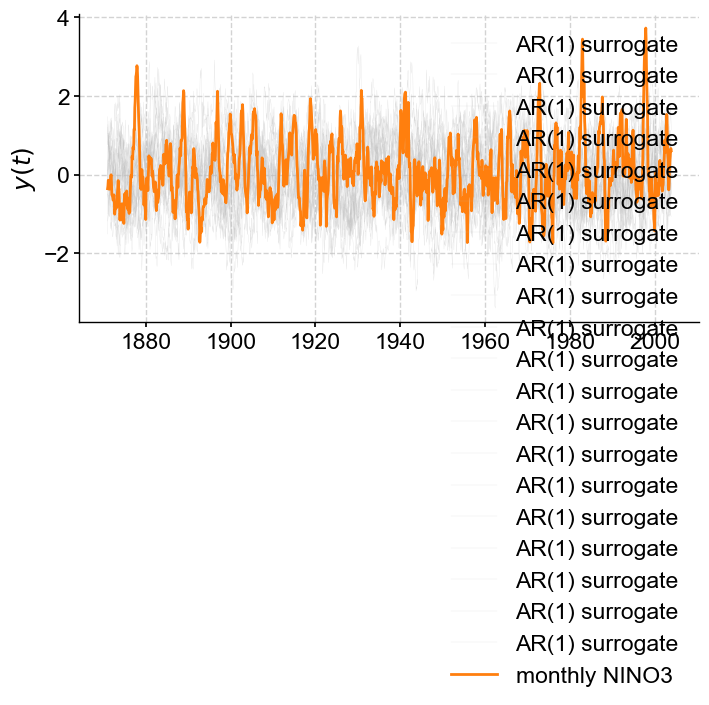

In [27]:
Yr = pyleo.tsmodel.ar1_sim(y, n , 500)

f = plt.figure(figsize=(8,4))
plt.plot(t,Yr[:,:20],alpha=0.5,color='silver',linewidth=0.2)
plt.plot(t,y,color='C1')
plt.ylabel(r'$y(t)$')
plt.legend()
pyleo.showfig(f)

Play with the new [autoregression](https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html) syntax. 

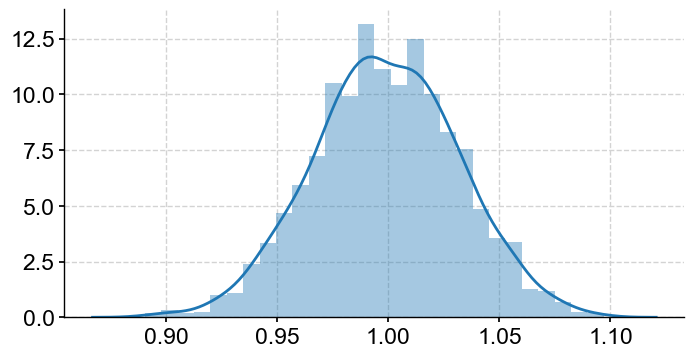

In [26]:
sr = np.std(Yr,axis=1)/np.std(y)
import seaborn as sns
f = plt.figure(figsize=(8,4))
sns.distplot(sr)
pyleo.showfig(f)

In [3]:
ar1_mod = AutoReg(y, 1, missing='drop').fit()
ar1_mod.summary()
ar1_mod.params

array([0.00504332, 0.94295918])

Useless. the API does not allow to simulate. The only one that does is https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.arma_generate_sample.html#statsmodels.tsa.arima_process.arma_generate_sample

In [4]:
import statsmodels.api as sm
mod1 = sm.tsa.ARMA(y, (1, 0)).fit(trend='nc', disp=0)
mod1.params

array([0.94305924])

In [5]:
from pyleoclim.utils.tsutils import standardize
ys, mu, sig = standardize(y)
mod2 = sm.tsa.ARMA(ys, (1, 0)).fit(trend='nc', disp=0)
mod2.params

array([0.94253863])

normalization doesn't matter. 

In [6]:
ar1_mod = sm.tsa.ARMA(y, (1, 0)).fit(trend='nc', disp=0)
g = ar1_mod.params[0]

ar = np.r_[1, -g]  # AR model parameter
ma = np.r_[1, 0.0]  # MA model parameters
sig_n = sig*np.sqrt(1-g**2)  # theoretical noise variance for Yr to achieve the same variance as y
yr = sm.tsa.ArmaProcess(ar, ma).generate_sample(nsample=n, scale=sig_n, distrvs=None, axis=0, burnin=50)

In [7]:
print(g)

0.9430592381171835


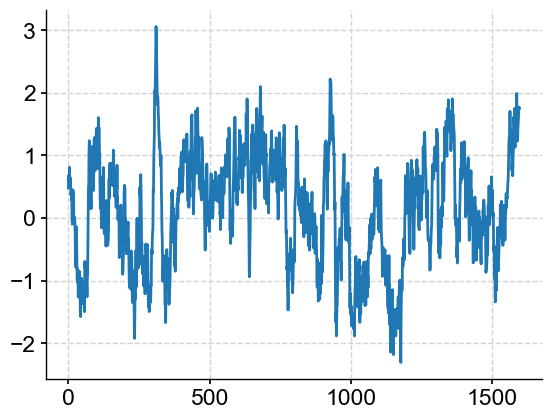

In [8]:
plt.plot(yr)
plt.show()

Test for missing values: it's tolerant!

In [9]:
yh = np.copy(y)
yh[100:300] = np.NaN
ar1_mod = sm.tsa.ARMA(yh, (1, 0), missing='drop').fit(trend='nc', disp=0)
g = ar1_mod.params[0]
print(g)

0.9425547664742925


In [10]:
np.random.seed(12345)
arparams = np.array(0.8)
maparams = np.array(0)
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
arma_process = sm.tsa.ArmaProcess(ar, ma)
arma_process.isstationary
arma_process.isinvertible
y = arma_process.generate_sample(1000)
model = sm.tsa.ARMA(y, (1, 1)).fit(trend='nc', disp=0)
model.params

array([0.77584411, 0.02202409])